# Who am I ?

- My name is *Pierre Navaro*

- Ph.D in Computational Aeroacoustics, 1998-2002 (Université du Havre) (Fortran 77+PVM)

- Scientific Software Engineer in Strasbourg (2003-2015) (Fortran 90-2003 + OpenMP-MPI)

- Moved to Rennes in 2015 (Numpy + Cython, R)

- Julia user since July 2018 (Julia v1.0)

# `bspline` function

In [26]:
"""
    bspline(p, j, x)

Return the value at x in [0,1[ of the B-spline with integer nodes 
of degree p with support starting at j.
Implemented recursively using the 
[De Boor's Algorithm](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

```math
B_{i,0}(x) := \\left\\{
\\begin{matrix}
1 & \\mathrm{if}  \\quad t_i ≤ x < t_{i+1} \\\\
0 & \\mathrm{otherwise}
\\end{matrix}
\\right.
```

```math
B_{i,p}(x) := \\frac{x - t_i}{t_{i+p} - t_i} B_{i,p-1}(x)
+ \\frac{t_{i+p+1} - x}{t_{i+p+1} - t_{i+1}} B_{i+1,p-1}(x).
```
"""
function bspline(p::Int, j::Int, x::Float64)
   if p == 0
       if j == 0
           return 1.0
       else
           return 0.0
       end
   else
       w = (x - j) / p
       w1 = (x - j - 1) / p
   end
   return (w * bspline(p - 1, j, x) 
           + (1 - w1) * bspline(p - 1, j + 1, x))
end

bspline

In [27]:
?bspline

search: bspline



```
bspline(p, j, x)
```

Return the value at x in [0,1[ of the B-spline with integer nodes  of degree p with support starting at j. Implemented recursively using the  [De Boor's Algorithm](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

$$
B_{i,0}(x) := \left\{
\begin{matrix}
1 & \mathrm{if}  \quad t_i ≤ x < t_{i+1} \\
0 & \mathrm{otherwise}
\end{matrix}
\right.
$$

$$
B_{i,p}(x) := \frac{x - t_i}{t_{i+p} - t_i} B_{i,p-1}(x)
+ \frac{t_{i+p+1} - x}{t_{i+p+1} - t_{i+1}} B_{i+1,p-1}(x).
$$


# `Advection` callable struct

In [28]:
"""
    Advection(n, p, delta)

    n :: Number of points.
    p :: Spline degree.
    delta :: space size step.
    
"""
mutable struct Advection
    n         :: Int64
    p         :: Int64
    delta     :: Float64
    modes     :: Vector{Float64}
    eig_bspl  :: Vector{ComplexF64}
    eig_alpha :: Vector{ComplexF64}
    
    function Advection( n, p, delta )
        
        eig_bspl  = zeros(ComplexF64,n)
        eig_alpha = similar(eig_bspl)
        modes = 2π * (0:n-1) / n
   
        eig_bspl .= bspline(p, -div(p+1,2), 0.0)
        for j in 1:div(p+1,2)-1
            eig_bspl .+= (bspline(p, j-div(p+1,2), 0.0)
             * 2 * cos.(j * modes))
        end
        
        new(n, p, delta, modes, eig_bspl, eig_alpha)
    end
end

Advection

In [33]:
using FFTW

"""
    advection! = Advection( n, p, delta)
    advection!( f, alpha )

    Create a function to compute the interpolating spline 
    of degree p of odd
    degree of a 1D function f on a periodic uniform mesh, at
    all points x after a displacement alpha. 
    Input f type is Vector{Float64} and is updated inplace.


"""
function (adv :: Advection)(f     :: Vector{Float64},
                            alpha :: Float64)

  
   ishift = floor(- alpha / adv.delta)
   beta = - ishift - alpha / adv.delta
   fill!(adv.eig_alpha, 0.0)
   for j in -div(adv.p-1,2):div(adv.p+1,2)
      adv.eig_alpha .+= (bspline(adv.p, j-div(adv.p+1,2), beta)
         .* exp.((ishift + j) * 1im .* adv.modes))
   end

   f .= real(ifft(fft(f) .* adv.eig_alpha ./ adv.eig_bspl))

end

Advection

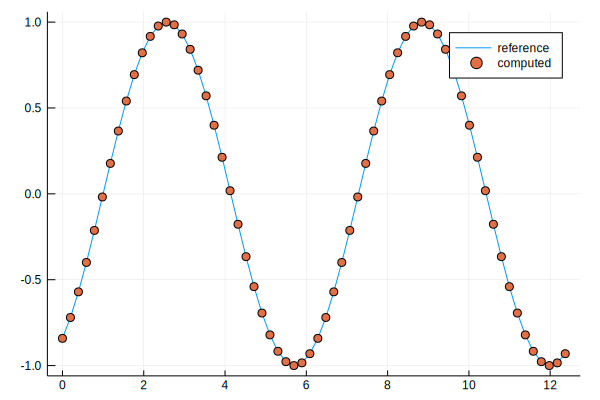

In [34]:
using Plots
xmin, xmax, nx = 0, 4π, 64
dx = (xmax - xmin) / nx
x = range(xmin, stop=xmax, length=nx+1)[1:end-1] |> collect

f = sin.(x) 
advection! = Advection(nx, 5, dx)
advection!(f, 1.0)
f_ref = sin.(x.-1) 
plot(x, f_ref, label=:reference)
scatter!(x, f, label=:computed)


# Why make a package ?

- Share your code and maintain it.
- Improve your programming practices (Testing).
- Continuous integration (Github+Travis-CI).
- Documentation generated automatically.
- Source files organization.

# Configure git

```bash
git config --global user.name "Pierre Navaro"
git config --global user.email "pierre.navaro@math.cnrs.fr"
git config --global github.user "pnavaro"
```

# Create the Julia package LyonCalcul

```julia
(v1.0) pkg> generate LyonCalcul
Generating project LyonCalcul:
    LyonCalcul/Project.toml
    LyonCalcul/src/LyonCalcul.jl
```

```julia
shell> cat LyonCalcul/Project.toml
authors = ["Pierre Navaro <pierre.navaro@math.cnrs.fr>"]
name = "LyonCalcul"
uuid = "417a5b38-18da-11e9-35ce-9bdc85ad86c9"
version = "0.1.0"

[deps]
```

```julia
shell> cat LyonCalcul/src/LyonCalcul.jl
module LyonCalcul

greet() = print("Hello World!")

end # module
```

```julia
module LyonCalcul

include("bspline.jl")
include("advection.jl")

end # module
```

# Activate your package

```julia
(v1.0) pkg> activate LyonCalcul

(LyonCalcul) pkg> instantiate
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/JuliaProjects/LyonCalcul/Project.toml`
 [no changes]
```

# Add dependencies
```julia
(LyonCalcul) pkg> add FFTW
 Resolving package versions...
  Updating `~/JuliaProjects/LyonCalcul/Project.toml`
  [7a1cc6ca] + FFTW v0.2.4
  Updating `~/JuliaProjects/LyonCalcul/Manifest.toml`
  [621f4979] + AbstractFFTs v0.3.2
  [b99e7846] + BinaryProvider v0.5.3
  [34da2185] + Compat v1.4.0
  [8f4d0f93] + Conda v1.1.1
  ...
```

" The Manifest.toml allows someone to replicate the exact version of the dependencies that was recorded in the manifest on e.g. another machine. For a package that is to be used as a library, this is not useful.

However, for an “application”, i.e. something at “top level” (say your julia code to do the simulations in a scientific paper) then it is likely useful to be able to replicate that exact state and the Manifest is thus useful to check in."


*Kristoffer Carlsson* (Julia Computing)

# Check the documentation

```julia
julia> using LyonCalcul

help?> bspline
search: bspline

  bspline(p, j, x)

  Return the value at x in [0,1[ of the B-spline with integer nodes of degree p with support starting at j.
  Implemented recursively using the De Boor's Algorithm (https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

B_{i,0}(x) := \left\{
\begin{matrix}
1 & \mathrm{if}  \quad t_i ≤ x < t_{i+1} \\
0 & \mathrm{otherwise}
\end{matrix}
\right.

B_{i,p}(x) := \frac{x - t_i}{t_{i+p} - t_i} B_{i,p-1}(x)
+ \frac{t_{i+p+1} - x}{t_{i+p+1} - t_{i+1}} B_{i+1,p-1}(x).
```

# Add a test

```bash
cd LyonCalcul
mkdir test
```

add file runtests.jl

```julia
shell> cat test/runtests.jl
using Test
using LyonCalcul

@testset "Test advection sinus function" begin

     xmin, xmax, nx = 0.0, 2π, 128
     dx = (xmax - xmin) / nx
     x = range(xmin, stop=xmax, length=nx+1)[1:end-1] |> collect
     f = sin.(x)
     advection! = Advection( nx, 5, dx )
     advection!( f, 0.5)
     @test maximum(abs.(f .- sin.(x .- 0.5))) ≈ 0.0 atol = 1e-12

end
```

## Verify the test

```julia
(LyonCalcul) pkg> test
   Testing LyonCalcul
 Resolving package versions...
Test Summary:             | Pass  Total
Test advection sinus function |    1      1
   Testing LyonCalcul tests passed
```

## Documentation

https://github.com/JuliaDocs/Documenter.jl

```julia
julia> using DocumenterTools
shell> pwd
/Users/navaro/JuliaProjects/LyonCalcul
julia> DocumenterTools.generate("docs")
[ Info: name of package automatically determined to be `LyonCalcul`.
[ Info: deploying documentation to `~/JuliaProjects/LyonCalcul/docs`
[ Info: Generating .gitignore at /Users/navaro/JuliaProjects/LyonCalcul/docs/.gitignore
[ Info: Generating make.jl at /Users/navaro/JuliaProjects/LyonCalcul/docs/make.jl
[ Info: Generating Project.toml at /Users/navaro/JuliaProjects/LyonCalcul/docs/Project.toml
[ Info: Generating src/index.md at /Users/navaro/JuliaProjects/LyonCalcul/docs/src/index.md
```

```julia
shell> cat docs/src/index.md
# LyonCalcul.jl

Documentation for LyonCalcul.jl

## Types and Functions
```

````   
```@autodocs
Modules = [LyonCalcul]
Order   = [:type, :function]
```
````




```julia
shell> cat docs/make.jl

using Documenter
using LyonCalcul

makedocs(modules=[LyonCalcul],
         doctest = false,
         format = Documenter.HTML(),
         sitename = "LyonCalcul.jl",
         pages = ["Documentation"    => "index.md"])

deploydocs(
    deps   = Deps.pip("mkdocs", "python-markdown-math"),
    repo   = "github.com/pnavaro/LyonCalcul.jl.git",
 )
```

# Add a repository on Github

https://github.com/pnavaro/LyonCalcul.jl

- Note : the repository name has the ".jl" extension

```bash
$ echo "# LyonCalcul.jl" >> README.md
$ git init
Initialized empty Git repository in /Users/navaro/JuliaProjects/LyonCalcul/.git/
$ git add .
```

```bash
$ git commit -m "first commit"
[master (root-commit) 8863c2e] first commit
 11 files changed, 287 insertions(+)
 create mode 100644 Manifest.toml
 create mode 100644 Project.toml
 create mode 100644 README.md
 create mode 100644 docs/.gitignore
 create mode 100644 docs/Project.toml
 create mode 100644 docs/make.jl
 create mode 100644 docs/src/index.md
 create mode 100644 src/LyonCalcul.jl
 create mode 100644 src/advection.jl
 create mode 100644 src/bspline.jl
 create mode 100644 test/runtests.jl
```

```bash
$ git remote add origin git@github.com:pnavaro/LyonCalcul.jl.git
$ git push -u origin master
Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 8 threads
Compressing objects: 100% (13/13), done.
Writing objects: 100% (17/17), 4.29 KiB | 2.15 MiB/s, done.
Total 17 (delta 0), reused 0 (delta 0)
To github.com:pnavaro/LyonCalcul.jl.git
 * [new branch]      master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.
```

### Ignore some files

```
$ cat .gitignore
*.jl.cov
*.jl.*.cov
*.jl.mem
docs/build/
docs/site/
Manifest.toml
```

### Install first version of Example package in your julia installation
```
(v1.1) pkg> add https://github.com/pnavaro/LyonCalcul.jl.git
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Cloning git-repo `https://github.com/pnavaro/LyonCalcul.jl.git`
  Updating git-repo `https://github.com/pnavaro/LyonCalcul.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
  [417a5b38] ~ LyonCalcul v0.1.0 [`~/JuliaProjects/LyonCalcul`] ⇒ v0.1.0 #master (https://github.com/pnavaro/LyonCalcul.jl.git)
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [417a5b38] ~ LyonCalcul v0.1.0 [`~/JuliaProjects/LyonCalcul`] ⇒ v0.1.0 #master (https://github.com/pnavaro/LyonCalcul.jl.git`
```

### Test it

```
(v1.1) pkg> test LyonCalcul
   Testing LyonCalcul
    
Test Summary:                 | Pass  Total
Test advection sinus function |    1      1
   Testing LyonCalcul tests passed
```

# Push the package on github

```bash
cd LyonCalcul
echo "# LyonCalcul.jl" >> README.md
git init
git add README.md
git commit -m "first commit"
git remote add origin git@github.com:pnavaro/LyonCalcul.jl.git
git push -u origin master
```

# On Github choose your license

Above the file list, click Create new file.

In the file name field, type LICENSE (with all caps).

- Choose a license template button.
- Click Choose a license template.
- Add a license to your project.
- Don't create pull request choose "master" branch.

# On your computer

```bash
git pull origin master
```

# Travis

https://travis-ci.org

- Profile -> Settings
-

# Items not covered

- Binary package [PackageCompiler.jl](https://github.com/JuliaLang/PackageCompiler.jl)
- Mixed language [BinDeps.jl](https://github.com/JuliaPackaging/BinDeps.jl)
- Simplifying working with Julia packages and dependencies [Julia Packaging](https://github.com/JuliaPackaging)